# Persona Discovery and Dataset Partitioning

This notebook demonstrates the process of discovering data-driven personas from the Cornell Movie-Dialogs Corpus and partitioning the dataset for each agent.


📊 Sentiment Stats by Cluster:

                    count      mean       std  min  25%  50%    75%  max
persona_cluster                                                         
0                165401.0  0.043599  0.243863 -1.0  0.0  0.0  0.000  1.0
1                 82795.0  0.035058  0.249485 -1.0  0.0  0.0  0.000  1.0
2                 56517.0  0.046361  0.247902 -1.0  0.0  0.0  0.125  1.0


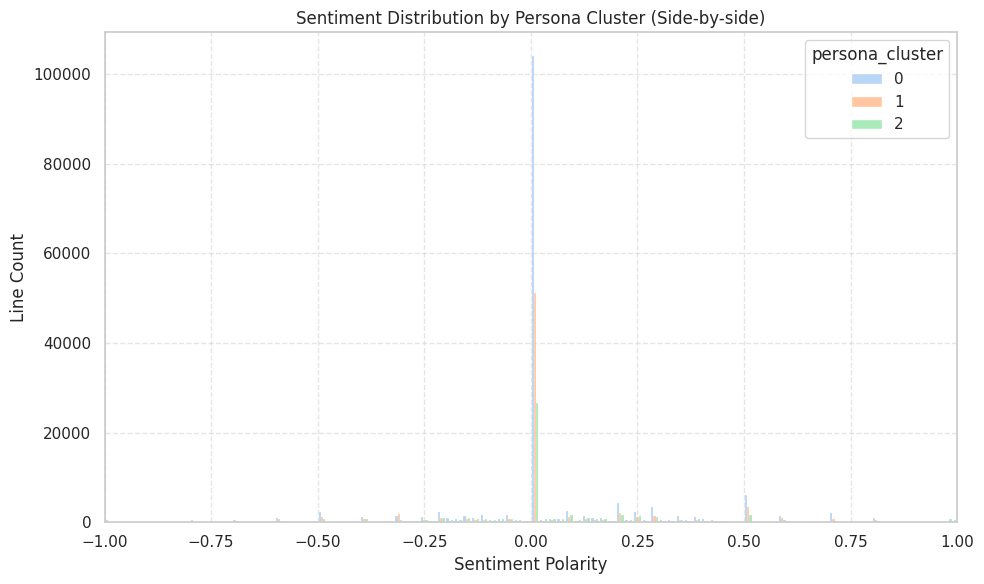

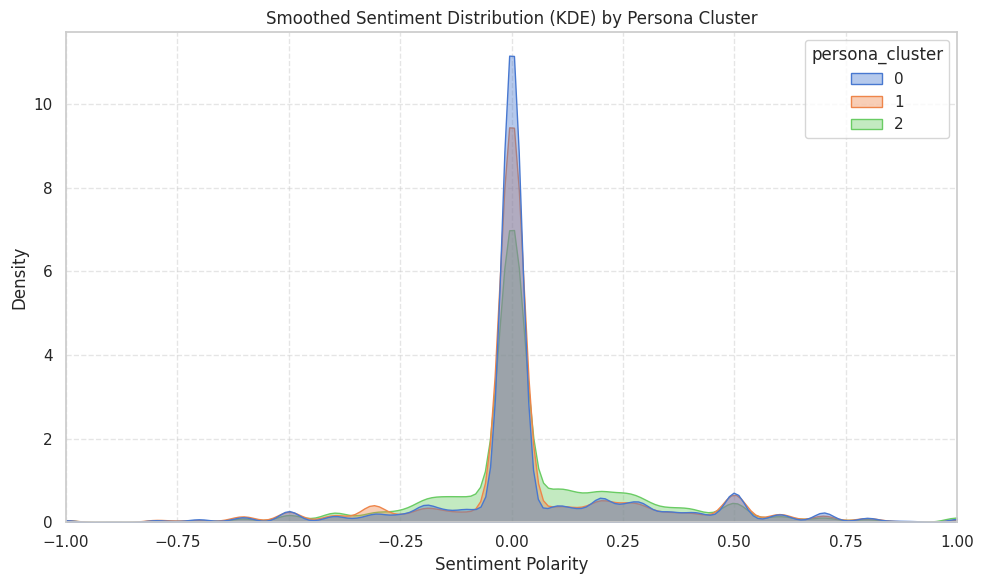

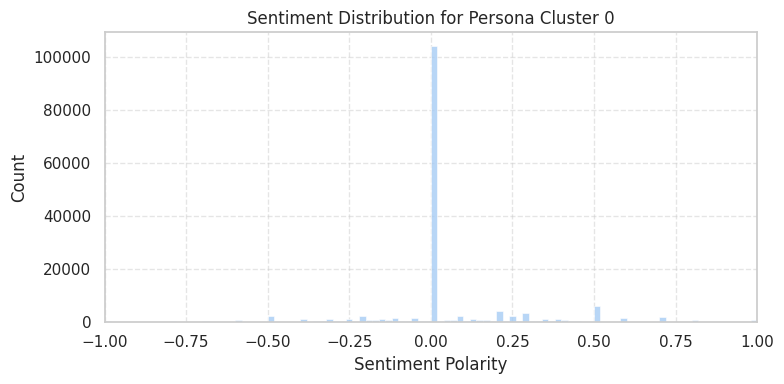

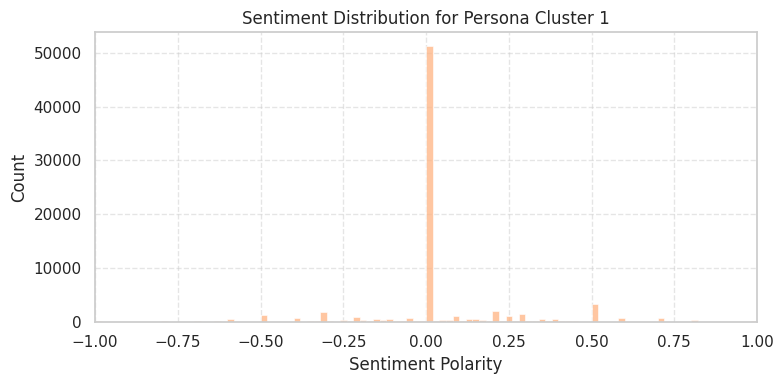

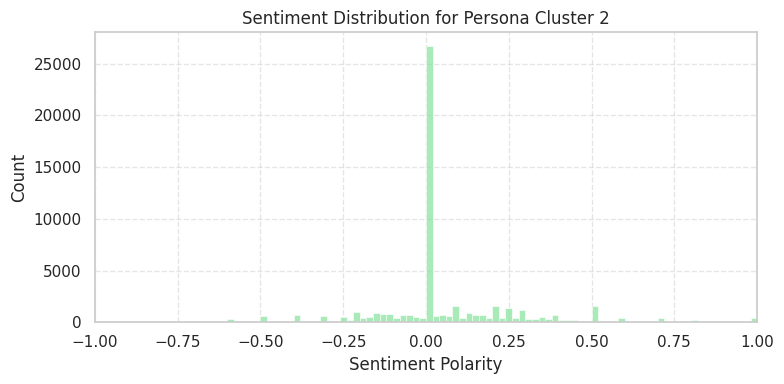

✅ Saved ../data/persona_0.csv with 165401 lines.
✅ Saved ../data/persona_1.csv with 82795 lines.
✅ Saved ../data/persona_2.csv with 56517 lines.


In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
import os

# Set Seaborn style
sns.set(style='whitegrid')

# === 1. Load the Cornell Movie-Dialogs Corpus ===
lines = pd.read_csv(
    '../data/movie_lines.csv',
    sep=' \+\+\+\$\+\+\+ ',
    engine='python',
    encoding='ISO-8859-1',
    names=['line_id', 'character_id', 'movie_id', 'character', 'text']
)

# === 2. Feature extraction ===
lines['length'] = lines['text'].apply(lambda x: len(str(x).split()))
lines['sentiment'] = lines['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
lines['question'] = lines['text'].apply(lambda x: '?' in str(x))
lines['exclaim'] = lines['text'].apply(lambda x: '!' in str(x))
lines['unique_word_ratio'] = lines['text'].apply(
    lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-5)
)

# === 3. TF-IDF Vectorization + KMeans Clustering ===
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(lines['text'].astype(str))
kmeans = KMeans(n_clusters=3, random_state=42)
lines['persona_cluster'] = kmeans.fit_predict(X)

# === 4. Sentiment Stats ===
print("\n📊 Sentiment Stats by Cluster:\n")
print(lines.groupby('persona_cluster')['sentiment'].describe())

# === 5. Sentiment Distribution: Side-by-Side Histogram ===
plt.figure(figsize=(10, 6))
sns.histplot(
    data=lines,
    x='sentiment',
    hue='persona_cluster',
    bins=100,
    multiple='dodge',
    shrink=0.8,
    palette='pastel'
)
plt.title('Sentiment Distribution by Persona Cluster (Side-by-side)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Line Count')
plt.xlim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. KDE Plot ===
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=lines,
    x='sentiment',
    hue='persona_cluster',
    fill=True,
    common_norm=False,
    alpha=0.4,
    palette='muted'
)
plt.title('Smoothed Sentiment Distribution (KDE) by Persona Cluster')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.xlim(-1, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 7. Per-cluster Histogram ===
for cluster in sorted(lines['persona_cluster'].unique()):
    plt.figure(figsize=(8, 4))
    sns.histplot(
        lines[lines['persona_cluster'] == cluster],
        x='sentiment',
        bins=100,
        color=sns.color_palette('pastel')[cluster]
    )
    plt.title(f'Sentiment Distribution for Persona Cluster {cluster}')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Count')
    plt.xlim(-1, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# === 8. Save Clusters to CSV ===
os.makedirs('../data', exist_ok=True)
for cluster in range(3):
    persona_df = lines[lines['persona_cluster'] == cluster]
    output_path = f'../data/persona_{cluster}.csv'
    persona_df.to_csv(output_path, index=False)
    print(f'✅ Saved {output_path} with {len(persona_df)} lines.')
